# PyTorch: Classifying Phishing websites with an Atribute-Level RNN

To detect whether a given URL has a high probability of being a Phishing Website, we make use of a Recurrent Neural Network (RNN) as an attribute-level classifier for Website URLs.

The RNN will read each URL as a series of attributes, outputting a prediction and "hidden state" at each step, and feeds its previous hidden state into each next step. We will take the final prediction to be the output, i.e. which class the URL belongs to: Phishing Website, or Non-Phishing Website.

# Preparing the Data

For this network, we used a CSV file containing the Phishing Website URLs that were split into attributes. The data can be downloaded separately at https://phishtank.com/. 

Specifically, we used 10,988 URLs from the PhishTank Database (As of March 31, 2022), confirmed to be either a Phishing Website URL or a Non-Phishing Website URL, in order to train our network.

In [373]:
import numpy as np
import pandas as pd
import torch
import random

# Use Pandas to read the CSV data file
data_file = pd.read_csv('../data/data.csv')
data = data_file.values.tolist()

# Randomly shuffle the data
random.shuffle(data)

# Set class labels
labels = ["Non-Phishing Website", "Phishing Website"]
labels_tensor = torch.LongTensor([0,1])

# Converting Data into Tensors

We first split the data into Training Data and Test Data. We allocate 2000 of the examples to be Test Data.

Then, we turn each of the obtained data and the corresponding labels into tensors. Hence, each URL will correspond to a single 1 x 16 Tensor, where 16 corresponds to the 16 attributes that each URL has.

Each URL has a label of either 1 (Phishing Website) or 0 (Non-Phishing Website).

In [374]:
# Set training data and test data sizes
data_size = len(data)
test_data_size = 2000
training_data_size = data_size - test_data_size

# Extract out training data and test data
training_data_domain = []
training_data = []
training_label = []

test_data_domain = []
test_data = []
test_label = []

for i in range(training_data_size):
    training_data_domain.append(data[i][0])
    training_data.append(data[i][1:-1])
    training_label.append(data[i][-1])

for i in range(test_data_size):
    test_data_domain.append(data[i+training_data_size][0])
    test_data.append(data[i+training_data_size][1:-1])
    test_label.append(data[i+training_data_size][-1])

# Convert the data into PyTorch Tensors
training_data = torch.Tensor(training_data)
training_label = torch.Tensor(training_label)
test_data = torch.Tensor(test_data)
test_label = torch.Tensor(test_label)

print(training_data.size())
print(training_label.size())
print(test_data.size())
print(test_label.size())

torch.Size([8988, 16])
torch.Size([8988])
torch.Size([2000, 16])
torch.Size([2000])


# Creating the Network

This RNN has been largely taken from [the PyTorch for Torch users tutorial](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb). It is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

In [375]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        # Define the input, hidden, and output sizes of the network
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Define the two linear layers, with Softmax as the non-linear layer
        self.input_to_hidden_layer = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_to_output_layer = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, input, hidden):
        
        # Resize the input into a 1 x 16 Tensor
        resized_input = torch.unsqueeze(input, dim = 0)
        
        # Combine the input and the hidden layer into a single Tensor, for the training process
        combined = torch.cat((resized_input, hidden), 1)
        
        # Run the Tensor through the network
        hidden = self.input_to_hidden_layer(combined)
        output = self.input_to_output_layer(combined)
        output = self.softmax(output)
        
        # Return the results of the network
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

## Manually testing the network

With our custom `RNN` class defined, we can create a new instance:

In [376]:
num_of_attributes = 16
hidden_size = 128
num_of_labels = 2
net = RNN(num_of_attributes, hidden_size, num_of_labels)

To run a step of this network, we can pass in an input (in this case, the features for the first URL in our att_set) and a previous hidden state (Initialized as zeros at first). 

We will get back the output (probability of each label) and a next hidden state (which we keep for the next step).

In [377]:
input = Variable(training_data[0])
hidden = net.init_hidden()

output, next_hidden = net(input, hidden)
print('output size =', output.size())
print(output)

output size = torch.Size([1, 2])
tensor([[-0.4929, -0.9438]], grad_fn=<LogSoftmaxBackward>)


We then run another step of the network using the second set of attributes from our att_set.

In [378]:
input = Variable(training_data[1])
hidden = Variable(torch.zeros(1, hidden_size))

output, next_hidden = net(input, hidden)
print(output)

tensor([[-0.6206, -0.7714]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a `<1 x num_of_labels>` Tensor, where every item is the likelihood of the label (higher is more likely).

# Preparing for Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each label. We can use `Tensor.topk` to get the index of the greatest value:

In [379]:
def category(output):
    
    # Tensor out of Variable with .data
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return "Prediction: " + labels[category_i]

print(category(output))

Prediction: Non-Phishing Website


We will also want a quick way to get a training example (A set of attributes and its true label) from a given index.

In [384]:
def get_training_example(index, train=True):
    
    if (train):
        # Use the random integer to select a particular training example
        attribute_tensor = training_data[index]
        attribute = attribute_tensor.tolist()
        label_tensor = torch.LongTensor([training_label[index]])
        label = int(label_tensor.item())
    
        # Return the Attribute, Label, and their corresponding Tensors
        return attribute, label, attribute_tensor, label_tensor

    else:
        # Use the random integer to select a particular training example
        attribute_tensor = test_data[index]
        attribute = attribute_tensor.tolist()
        label_tensor = test_label[index]
        label = int(label_tensor.item())
    
        # Return the Attribute, Label, and their corresponding Tensors
        return attribute, label, attribute_tensor, label_tensor
    
for i in range(10):
    attribute, label, attribute_tensor, label_tensor = get_training_example(i)
    print('\nAttribute =', attribute, '\nLabel =', labels[label], '\n')


Attribute = [0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0] 
Label = Non-Phishing Website 


Attribute = [0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0] 
Label = Phishing Website 


Attribute = [0.0, 0.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0] 
Label = Non-Phishing Website 


Attribute = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0] 
Label = Phishing Website 


Attribute = [0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0] 
Label = Phishing Website 


Attribute = [0.0, 0.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0] 
Label = Non-Phishing Website 


Attribute = [0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0] 
Label = Phishing Website 


Attribute = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0] 
Label = Phishing Website 


Attribute =

We may also define a handy function to get the error of the network:

In [385]:
def get_error(scores, labels):

    batch_size = scores.size(0)
    predicted_labels = scores.argmax(dim = 1)
    indicator = (predicted_labels == labels)
    num_of_matches = indicator.sum()
    
    return 1 - num_of_matches.float() / batch_size

Finally, we may define a function to evaluate our network on the test set:

In [386]:
def evaluate_on_test_data():

    running_error = 0
    num_batches = 0

    for i in range(0, test_data_size):

        attribute, label, attribute_tensor, label_tensor = get_training_example(shuffled_indices[i].item(), False)
        
        scores = net(attribute_tensor)
        error = get_error(scores, labels_tensor)
        running_error += error.item()
        num_batches += 1

    total_error = running_error / num_batches
    print('test error =', total_error*100 ,'percent')

# Training the Network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the [loss function `nn.NLLLoss`](http://pytorch.org/docs/nn.html#nllloss) is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.

We will also use an initial Learning Rate of 0.05, but throughout the training process, we will continuously decrease the Learning Rate every 10 epochs. This will ensure a faster Gradient Descent in the beginning and a slower (and hence more accurate) Gradient Descent later on.

In [387]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.05

Each loop of training will:

* Create input and target tensors
* Create a zeroed initial hidden state
* Read each set of attributes in and
    * Keep hidden state for next set of attributes
* Compare final output to target
* Back-propagate
* Return the output and loss

Now we just have to run that with a bunch of examples. 

Since the `train` function returns both the output and loss, we can print its guesses and also keep track of loss for plotting. 

And since there are thousands of examples, we print only every batch, and take an average of the loss.

In [393]:
import time
import math

num_of_epochs = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

# Start the training process
for epoch in range(num_of_epochs):
    
    # Learning rate strategy: divide the learning rate by 1.5 every 10 epochs
    if epoch % 10 == 0 and epoch > 10: 
        learning_rate = learning_rate / 1.5
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.  
    optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
    
    running_loss = 0
    running_error = 0
    num_batches = 0
    
    shuffled_indices = torch.randperm(training_data_size)
    hidden = net.init_hidden()
    
    for count in range(0, training_data_size):
        
        # Forward and Backward Passes
    
        optimizer.zero_grad()
        
        attribute, label, attribute_tensor, label_tensor = get_training_example(shuffled_indices[i].item(), True)
        attribute_tensor.requires_grad_()   
        output, hidden = net(attribute_tensor, hidden)
        
        loss = criterion(output, label_tensor)
        loss.backward()
        optimizer.step()
        
        # Compute some stats
        
        running_loss += loss.detach().item()
               
        error = get_error(output.detach(), label_tensor)
        running_error += error.item()
        
        num_batches += 1
    
    # Once the epoch is finished, we divide the "running quantities" by the number of batches
    total_loss = running_loss / num_batches
    total_error = running_error / num_batches
    elapsed_time = time.time() - start
    
    # Every 10 epoch, we display the stats and compute the error rate on the test set  
    if epoch % 10 == 0 : 
    
        print(' ')
        print('epoch=',epoch, '\ntime=', elapsed_time, '\nloss=', total_loss , '\nerror=', total_error*100 ,'\nLearning Rate =', learning_rate)
        print(' ')
        
        evaluate_on_test_data()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [144, 128]], which is output 0 of TBackward, is at version 8; expected version 7 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

# Plotting the Results

Plotting the historical loss from `all_losses` shows the network learning:

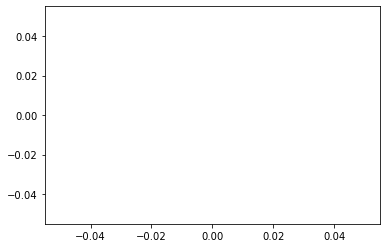

In [18]:
# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# %matplotlib inline

# plt.figure()
# plt.plot(all_losses)

# Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

/tmp/ipykernel_4310/3642150636.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)
/tmp/ipykernel_4310/828585331.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_4310/828585331.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


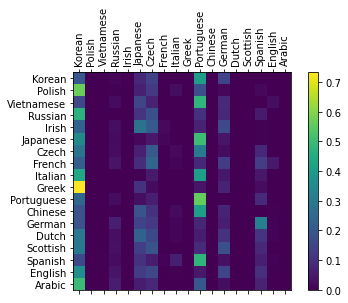

In [19]:
# # Keep track of correct guesses in a confusion matrix
# confusion = torch.zeros(n_categories, n_categories)
# n_confusion = 10000

# # Just return an output given a line
# def evaluate(line_tensor):
#     hidden = rnn.init_hidden()
    
#     for i in range(line_tensor.size()[0]):
#         output, hidden = rnn(line_tensor[i], hidden)
    
#     return output

# # Go through a bunch of examples and record which are correctly guessed
# for i in range(n_confusion):
#     category, line, category_tensor, line_tensor = random_training_pair()
#     output = evaluate(line_tensor)
#     guess, guess_i = category_from_output(output)
#     category_i = all_categories.index(category)
#     confusion[category_i][guess_i] += 1

# # Normalize by dividing every row by its sum
# for i in range(n_categories):
#     confusion[i] = confusion[i] / confusion[i].sum()

# # Set up plot
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(confusion.numpy())
# fig.colorbar(cax)

# # Set up axes
# ax.set_xticklabels([''] + all_categories, rotation=90)
# ax.set_yticklabels([''] + all_categories)

# # Force label at every tick
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

# Running on User Input

In [20]:
# def predict(input_line, n_predictions=3):
#     print('\n> %s' % input_line)
#     output = evaluate(Variable(line_to_tensor(input_line)))

#     # Get top N categories
#     topv, topi = output.data.topk(n_predictions, 1, True)
#     predictions = []

#     for i in range(n_predictions):
#         value = topv[0][i]
#         category_index = topi[0][i]
#         print('(%.2f) %s' % (value, all_categories[category_index]))
#         predictions.append([value, all_categories[category_index]])

# predict('Aaron')
# predict('Jackson')
# predict('Satoshi')


> Aaron
(-2.78) Japanese
(-2.79) German
(-2.82) Korean

> Jackson
(-2.78) German
(-2.79) Japanese
(-2.82) Italian

> Satoshi
(-2.72) Korean
(-2.79) Russian
(-2.81) German


/tmp/ipykernel_4310/3642150636.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


The final versions of the scripts [in the Practical PyTorch repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification) split the above code into a few files:

* `data.py` (loads files)
* `model.py` (defines the RNN)
* `train.py` (runs training)
* `predict.py` (runs `predict()` with command line arguments)
* `server.py` (serve prediction as a JSON API with bottle.py)

Run `train.py` to train and save the network.

Run `predict.py` with a name to view predictions: 

```
$ python predict.py Hazaki
(-0.42) Japanese
(-1.39) Polish
(-3.51) Czech
```

Run `server.py` and visit http://localhost:5533/Yourname to get JSON output of predictions.

# Exercises

* Try with a different dataset of line -> category, for example:
    * Any word -> language
    * First name -> gender
    * Character name -> writer
    * Page title -> blog or subreddit
* Get better results with a bigger and/or better shaped network
    * Add more linear layers
    * Try the `nn.LSTM` and `nn.GRU` layers
    * Combine multiple of these RNNs as a higher level network

**Next**: [Generating Shakespeare with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)